# 0. Introduction
## 0.1 Problem Definition
The need for physical activity has been established as a key aspect of achieving quality and longevity of life. Fitness programs and the use of gym facilities are popular methods through which physical activity is performed. Many people, especially younger age groups rely on digital sources such as fitness apps to assist them in achieving fitness.  

However, current fitness apps are a poor replacement for a personal trainer. They require a lot of manual input, and do not offer any feedback on the quality of exercise being performed. The result is users need to spend more time in gym on manual input and risk injury because of lack of feedback.

The first step in resolving this problem is to develop a system that can autonomously classify exercises. We believe that deep learning-based computer vision system can resolve this problem. The system can be enhanced to count repetitions (through simple programming) as well as to offer feedback (by training the model on good form markers).
## 0.2 Aims and Objectives
The main aim of this project is to develop and evaluate deep learning models for real-time exercise classification using video data. The specific objectives are:

1.   Track athletes skeletal model through each movement.
2.   Use movement tracking to classify multiple movements with a high degree of accuracy.
3. Implement and Evaluate performance of multiple classification models.

## 0.3 Deviation from Proposal
Our submitted proposal was focused on judging the quality of Olympic weightlifting movements. However, we soon realized that finding and labeling the dataset for this problem would be a very difficult task. The main problem was that such a problem would require many “bad lift” data which is difficult to find. Labeling the lifts with quality related data beyond “good” and “bad” would also have been difficult to achieve.

Considering these obstacles to data collection, we spoke to the Unit Leader and received his approval to work on a movement classification problem instead.


## 0.4 Notebook Organization
This notebook is organized as steps of our deep-learning pipeline, illusted in the diagram below:



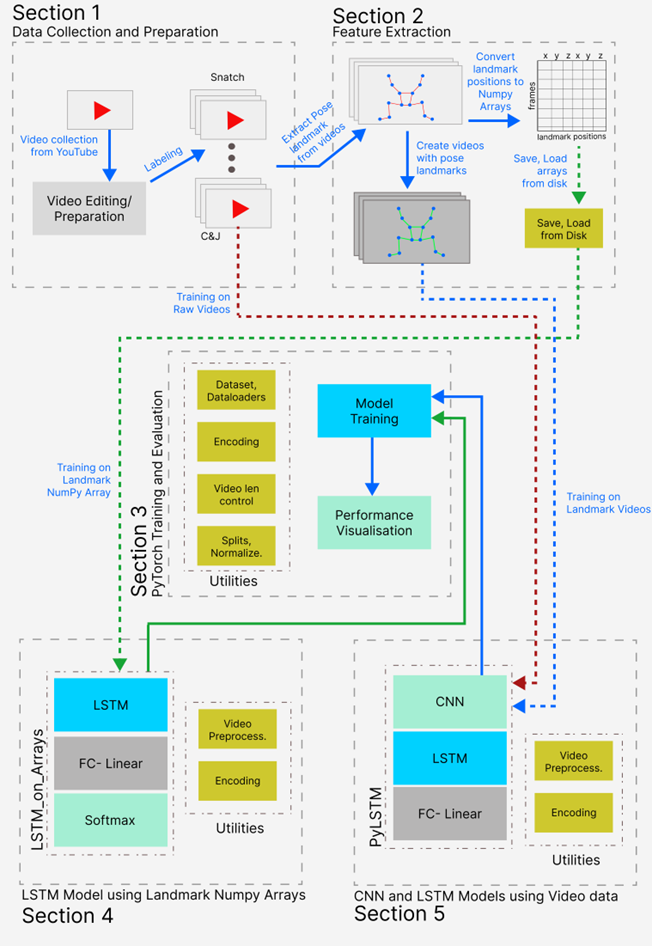

Section 1 comprises our data collection, preparation, and labeling tasks.

In Section 2, we perform our feature extraction steps which, as we shall see, will take two forms.

Section 3 builds the key training, evaluation and visualization functions that we'll use for all of our models. This section also includes some common pre-processing functions.

Section 4 focuses on model configuration, training, testing and reporting results for our main and preferred LSTM deep-learning model, which utilizes landmark positions.

Sections 5 covers a hybrid CNN-LSTM model that use video data in two forms. This section includes video-specific pre-processing, and then defining, creating, training and testing the model with the two forms of video-based datasets.

We evaluate model performance in Section 6 and conclude our work in Section 7.

# 1. Data Collection and Preparation
The base data for this project are videos of exercise movements being performed. We were unable to find a ready-made dataset that suited our requirements and thus had to create one ourselves. This process had two steps – firstly collecting the data and then preparing it to be used as part of the video dataset.

## 1.1 Collection and Labeling

Videos of three exercise movements (snatch, clean & jerk and sumo deadlift) were collected from YouTube. The total data collected includes 40 videos of each movement type. Each video of a particular exercise was labelled in the format ExerciseNameNN.mp4.   

## 1.2 Preparation

Since the videos downloaded from YouTube differed in terms of length, quality, frame size and orientation, they had to manually adjusted to serve as valid elements of the video dataset. These adjustments were carried out using video editing software like Adobe Premiere Pro.  

This step included cutting the videos to remove undesired parts to only shown a single repetition, resizing the videos to a standard size and resolution, and exporting the final videos to an mp4 format. As we shall see in further sections, editing the videos to standardize them is key to classification model performance.

Our preprared video dataset can be downloaded from GDrive:

In [1]:
!pip install torch
!pip install gdown

In [ ]:
!gdown 1Zq_VjC0PztL_ErN6lky9V_Wx_gw0rBx7
!unzip -q data.zip

# 2. Feature Extraction
## 2.1 Purpose and Approach
One possible method to train models to classify exercise movements is to utilize video data directly. However, this approach has several disadvantages. Firstly, using raw videos directly isn’t viable due to the time and computation resources needed. Secondly, the model will remain susceptible to noise in the video background.

A better approach is to extract features from the video that contains the ‘signature’ of each exercise. From our earlier fitness-related reading, we recalled that simplified skeletal model diagrams are often used to depict movement patterns and key positions while teaching more complex movements, such as:

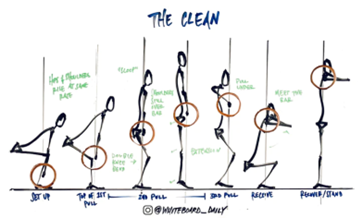

We reasoned that since skeletal model movement patterns for each exercise vary significantly, it would be an appropriate feature to extract from the video data to train our classification model.

Considering the above, we implement feature extraction as a two-step process. First, we utilize Mediapipe to extract the skeletal model of the athlete performing the lift. We then convert the skeletal model into numpy arrays, ready to be fed to the deep-learning model.


## 2.2 Mediapipe
Mediapipe (https://developers.google.com/mediapipe) is a library available across an array of platforms and languages. Created by Google in 2012, the library is an open-source framework dedicated to building machine-learning applications involving images, video and audio.

We utilize MediaPipe’s BlazePose model, which provides human pose tracking, implemented through machine learning to infer 33 “landmarks” of a body from each frame provided to it. The landmarks inferred by BlazePose are shown below:

(graphic from: https://ai.googleblog.com/2020/08/on-device-real-time-body-pose-tracking.html)


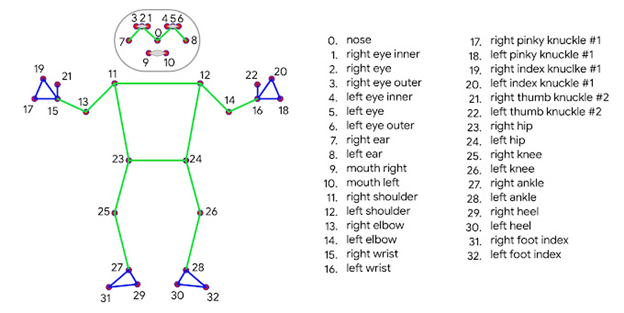

BlazePose utilizes a proprietary two-step detector-tracker ML pipeline. The detector determines the region of interest in the frame, which the tracker then uses to predict locations of the 33 landmarks:

Diagram from https://ai.googleblog.com/2020/08/on-device-real-time-body-pose-tracking.html

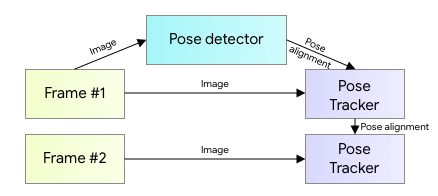

For video data, such as our project, the pose library only uses the pose detector pipeline step on the first frame. Tracking for Frames 2 and beyond uses locations of landmarks predicted in the preceding frame.

We demonstrate the use of MediaPipe and BlazePose below by showing a raw video (input and generating a video showing the inferred 33 pose landmarks.

Required installation first:

In [2]:
!pip install mediapipe

Also adding 'output' videos, which as we shall see, will be used for training one our of "proof-of-concept" models.

In [5]:
!gdown 1I3yFU0GI2Yjwz1D-r9fz5BpxAykklpR7
!unzip -q output.zip

Downloading...
From (original): https://drive.google.com/uc?id=1I3yFU0GI2Yjwz1D-r9fz5BpxAykklpR7
From (redirected): https://drive.google.com/uc?id=1I3yFU0GI2Yjwz1D-r9fz5BpxAykklpR7&confirm=t&uuid=39cc6c6e-4228-4c39-ae52-ec3d8275209e
To: /home/jupyter/output.zip
100%|█████████████████████████████████████████| 374M/374M [00:02<00:00, 166MB/s]


All imports needed:

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import numpy as np
import mediapipe as mp
from IPython.display import HTML
from base64 import b64encode

import torch as tc
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

import random

ModuleNotFoundError: No module named 'tensorflow'

A useful .mp4 video display function, which takes the file name as input, reads the file, performs encodig in base64 then creates HTML to embed and display the video within the notebook.

In [ ]:
def read_video(file_name):
  with open(file_name, 'rb') as mp4:
    mp4 = mp4.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""<video width=600 height=500 muted controls><source src="{data_url}"></video>""")

A sample "input" video of snatch from our prepared dataset:

In [ ]:
read_video('data/snatch/snatch12.mp4')

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

The function below uses mediapipe BlazePose library to infer the pose landmarks discussed previously on the input video shown above.

It uses cv2 library to capture video as well as to write frames to the output video.

In [ ]:
def generate_landmark_video(input_file,out_file):

    output_file = out_file
    cap = cv2.VideoCapture(input_file)
    if not cap.isOpened():
        print("Error opening video file")

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            success, img = cap.read()
            if not success:
                break

            img_frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = pose.process(img_frame)

            out_black = np.zeros_like(img)
            mp_drawing.draw_landmarks(out_black, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            out.write(out_black)

            cv2.imshow('Lifting Skeletal Tracker', out_black)

            if cv2.waitKey(5) & 0xFF == 27:
                    break

    cap.release()
    cv2.destroyAllWindows()

As can be seen below, the sample output video created by the function above, marks the 33 pose landmarks inferred by Mediapipe BlazePose.

In [ ]:
read_video('output/output.mp4')

## 2.3 Skeletal Model to Numpy Array

As seen above, BlazePose provides us with pose landmarks for each frame of the video. Each landmark object contains the x, y, z coordinates of the landmark for that frame. The key point is that the order in which the 33 landmarks are reported through the pose object remains the same for each frame and for each video. In this way, change in each landmark’s positions as the exercise progresses, frame by frame, form the unique signature for each exercise that we seek.

The function below extracts the pose landmarks for video whose path is provided to it and returns them as a flattened 2D array. Each row of the array contains positions of landmarks of a single video frame. There are 99 columns as they store x, y, z coordinates of 33 landmarks.


In [ ]:
def extract_landmarks_array(input_file, sub_folder, file_name):
    output_file = os.path.join('output', sub_folder, file_name)
    cap = cv2.VideoCapture(input_file)
    if not cap.isOpened():
        print("Error opening video file")

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        lm_list = []
        while cap.isOpened():
            success, img = cap.read()
            if not success:
                break

            img_frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = pose.process(img_frame)

            out_black = np.zeros_like(img)
            mp_drawing.draw_landmarks(out_black, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            out.write(out_black)

            if results.pose_landmarks is not None:
                lm_list.append(results.pose_landmarks)
            #print(lm_list)
    cap.release()

    #each element of lm list now has the landmarks in each frame.
    num_frames = len(lm_list)
    num_lm = len(lm_list[0].landmark)
    #lm array- 2D, rows = frames, each 3 cols represent x,y,z of each landmark.
    lm_array = np.zeros((num_frames, num_lm * 3))
    i=0
    for frame_lms in lm_list:
        frame_data = []
        for lm in frame_lms.landmark:
            frame_data.extend([lm.x, lm.y, lm.z])
        lm_array[i] = frame_data
        i +=1
    return lm_array

The below function, works in conjunction with the function above to extract pose landmarks for the entire dataset of prepared videos, given its directory path. The function returns a list of landmark arrays, one each element of the list capturing the information of all frames of a single video. The function also returns a corresponding labels list.

In [ ]:
def fetch_dataset(directory_path):

    sub_folders = ['jerk', 'snatch','sumo']
    movements = []
    lm_arrays = []

    for sub_folder in sub_folders:
        sub_folder_path = os.path.join(directory_path, sub_folder)
        for file in os.listdir(sub_folder_path):
            if file.endswith('.mp4'):
                file_path = os.path.join(sub_folder_path, file)
                movements.append(sub_folder)

                lm_array = extract_landmarks_array(file_path)
                lm_arrays.append(lm_array)

    movements = np.array(movements)
    return movements, lm_arrays

Extracting landmark arrays from video data is a time-intensive job. To make our task easier, we created functions that save these data to an npz file and can load from it.  

In [ ]:
#Saves Landmark arrays and correspnding movements list to an .npz file.
def save_lm_arrays(movements, lm_arrays, arrayfilename):

    lm_arrays_list = [arr.tolist() for arr in lm_arrays]
    lm_arrays_object = np.array(lm_arrays_list, dtype=object)
    np.savez_compressed(arrayfilename, movements=movements, lm_arrays=lm_arrays_object)

#Loads Landmark arrays and  movements list from an .npz file.
def load_lm_arrays(arrayfilename):

    with np.load(arrayfilename + ".npz", allow_pickle=True) as data:
        movements = data['movements']
        lm_arrays_object = data['lm_arrays']
    lm_arrays = [np.array(arr) for arr in lm_arrays_object]
    return movements, lm_arrays

This is a utility function that we've used previously to create the Landmark array dataset and save to file.

After achieving correct functionality, we did not need to repeat this step as we simply load from the saved .npz file using the load_lm_arrays function. Hence the final notebook does not have any calls to this function.

In [ ]:
def make_arrays_file(video_directory_path, array_filename):

  movements, lm_arrays = fetch_dataset(video_directory_path)
  save_lm_arrays(movements, lm_arrays, array_filename)

# 3. Training, Evaluation and Visualization
## 3.1 PyTorch Training and Evaluation
In this section, we implement a generic training and evaluation function to test all of our PyTorch models.

The functions inputs the model objection, datasets and loaders and number of epochs. It trains the model on the training dataset and evaluates its performance on test data. It returns losses, accuracy and F1 sores of both training and test datasets for all epochs.

In [ ]:
def train_and_eval(model, loss_func, optimizer, train_dataset, train_dataloader, test_dataset, test_loader, num_epochs):

  #Empty lists for performance metrics- train and test, each epoch
  train_losses = []
  train_accuracies = []
  train_f1_scores = []

  test_losses = []
  test_accuracies = []
  test_f1_scores = []

  for epoch in range(1, num_epochs+1):
      # set to training mode.
      model.train()
      total_train_epoch_loss = 0
      total_train_epoch_correct = 0
      train_epoch_f1 = 0
      # training loop
      for  inputs, labels in train_dataloader:
          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs.float())
          loss = loss_func(outputs, labels)

          # Backward pass and optimize
          loss.backward()
          optimizer.step()

          # Update the total loss
          total_train_epoch_loss += loss.item()

          # Compute the predicted class labels
          _, predicted = tc.max(outputs.data, 1)

          # Compute f1-score of batch
          train_epoch_f1 += f1_score(labels.numpy(), predicted.numpy(), average='macro')

          # Update the total number of correct predictions
          total_train_epoch_correct += (predicted == labels).sum().item()

      # Compute the average loss and accuracy for the epoch
      avg_loss = total_train_epoch_loss / len(train_dataloader)
      train_losses.append(avg_loss)
      train_acc = total_train_epoch_correct / len(train_dataset)
      train_accuracies.append(train_acc)
      avg_f1 = train_epoch_f1 / len(train_dataloader)
      train_f1_scores.append(avg_f1)

      # Set model to testing mode
      model.eval()
      total_test_epoch_loss = 0
      total_test_epoch_correct = 0
      test_epoch_f1 = 0
      # Print statistics
      if (epoch % (num_epochs // 10) == 0):
        print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch, num_epochs, avg_loss))

      with tc.no_grad():
          #evaluation loop
          for inputs, labels in test_loader:

              # Forward pass
              outputs = model(inputs.float())
              loss = loss_func(outputs, labels)

              ## Update the total loss
              total_test_epoch_loss += loss.item()

              # Compute the predicted class labels
              _, predicted = tc.max(outputs.data, 1)

              # Compute f1-score of batch
              test_epoch_f1 += f1_score(labels.numpy(), predicted.numpy(), average='macro')

              # Update the total number of correct predictions
              total_test_epoch_correct += (predicted == labels).sum().item()
          # Compute the average loss and accuracy for the epoch
          avg_loss = total_test_epoch_loss / len(test_loader)
          test_losses.append(avg_loss)
          test_acc = total_test_epoch_correct / len(test_dataset)
          test_accuracies.append(test_acc)
          avg_f1 = test_epoch_f1 / len(test_loader)
          test_f1_scores.append(avg_f1)
          if (epoch % (num_epochs // 10) == 0):
            print(f"\nTest Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.4f}\n")

  for module in model.modules():
    if hasattr(module, 'reset_parameters'):
        module.reset_parameters()

  return train_losses, train_accuracies, train_f1_scores, test_losses, test_accuracies, test_f1_scores

## 3.2 Visualization
This function plots the results returned from the Training and Evalution function above for both training and testing splits.

In [ ]:
def plot_results(train_losses, train_accuracies, train_f1_scores, test_losses, test_accuracies, test_f1_scores, num_epochs):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

  fig.tight_layout(pad=3)
  #first plot to show model loss for train and test splits
  ax1.plot(train_losses)
  ax1.plot(test_losses)
  ax1.set_title('model loss')
  #loss on y-axis, epoch no. on x.
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('epoch')
  ax1.set_xticks(np.arange(0, num_epochs+1, num_epochs // 10))
  ax1.legend(['train loss', 'test loss'], loc='upper right')

  #Second plot to show model accuracy for train and test splits
  ax2.plot(train_accuracies)
  ax2.plot(test_accuracies)
  ax2.set_title('model accuracy')
  #accuracy on y-axis, epoch no. on x.
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_xticks(np.arange(0, num_epochs+1, num_epochs // 10))
  ax2.legend(['train accuracy', 'test accuracy'], loc='lower right')

  #Third plot to show model F1 score for train and test splits
  ax3.plot(train_f1_scores)
  ax3.plot(test_f1_scores)
  ax3.set_title('model F1-score')
  #F1 score on y-axis, epoch no. on x.
  ax3.set_ylabel('F1-score')
  ax3.set_xlabel('epoch')
  ax3.set_xticks(np.arange(0, num_epochs+1, num_epochs // 10))
  ax3.legend(['train f1-score', 'test f1-score'], loc='lower right')

  plt.show()

## 3.3 General Pre-processsing functions

For the models that we intend to train, test and compare, a number of generic functions are needed.

The purpose of each function is explained through comments.

In [ ]:
# This function extracts landmark infomation of first 'row' (currently set to 80) frames
# and returns a PyTorch tenson for it.

def get_video_begin(lm_arrays, row=80, col=99):
  X = np.zeros((len(lm_arrays),row,col))
  for i in range(len(lm_arrays)):
      X[i] = (lm_arrays[i])[:row, :]

  return tc.from_numpy(X)

# This function our class variable list (movements) which has three unique values,
# encodes it as a numercial value and returns a PyTorch sensor

def convert_to_class(movements):
  encoder = LabelEncoder()
  y = encoder.fit_transform(movements)
  return tc.from_numpy(y)

# this function creates PyTorch TensorDataset objects for training and testing splits
# and then uses these to create dataloaders
def get_sets_and_loaders(X_train, X_test, y_train, y_test):
  train_dataset = TensorDataset(X_train, y_train)
  train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
  test_dataset = TensorDataset(X_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
  return train_dataset, train_dataloader, test_dataset, test_loader

## 3.4 Splitting

The landmarks array’s length is 132 of 2D arrays with different shapes since each video has a different number of frames. We split the data into two sets: A training set and a test set. The split ratio was 90% for the training set and 10% for the test set (119 training examples and 13 test examples). This splitting ratio allows the model to train from the most data available while having enough test data to evaluate its performance.

## 3.5 Normalization

The normalization of the data consists of subtracting the mean and dividing by the standard deviation of the dataset. However, to avoid data leakage we run this step after splitting, by calculating the mean and the standard deviation of the training set instead of the entire dataset and using these values to normalize.

In [ ]:
# This function splits the dataset (X, y) into training and test sets.
# It is currently set to normalizing the pose landmark array data for each split seperately.
def generate_splits(X, y, split=0.15, norm=True):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)

  if norm:
    mean = X_train.mean()
    std = X_train.std()

    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

  return X_train, X_test, y_train, y_test

# 4. Model using Landmark Numpy Arrays
In this section, we train a LSTM model on the NumPy arrays that we generated based on the mediapipe landmarks.

## 4.1 Model Definition
The model is composed of two layers: LSTM and linear. The LSTM’s architecture varies based on the data that it is fed. The fully connected linear layer that takes the output of the LSTM as an input, runs it through a linear layer followed by a Softmax activation function given the task is multi-class classification.

In [ ]:
class LSTM_on_Arrays(nn.Module):
    def __init__(self, num_classes):
        super(LSTM_on_Arrays, self).__init__()

        self.lstm = nn.LSTM(input_size=99, hidden_size=6, batch_first=True)
        self.fc = nn.Linear(in_features=6, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        fc_output = self.fc(lstm_output[:, -1, :])
        output = self.softmax(fc_output)
        return output

## 4.2 Model Creation

We use the defined LSTM model to create a model for our 3-class classification problem.

In [ ]:
model = LSTM_on_Arrays(num_classes=3)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

To generate the landmark arrays, we run the **'make_arrays_file ()'** function. Having done that on our dataset locally, we uploaded the output file to drive to avoid having a long runtime each time we need it. The file is named **'lm_arrays.npz'** and it contains a list of the landmark arrays and an array of the labels of each landmark array.

In [ ]:
video_directory_path = 'data'
array_filename = "lm_arrays"
movements, lm_arrays = load_lm_arrays(array_filename)

## 4.3 Model Training

Pytorch LSTMs require the size of the inputs to be the same. But as mentioned above, the arrays have different shapes because of having different number of frames per video. To overcome this issue, we tried two approaches:


1.   **Data padding:** which means adding zeros or some other value to the arrays to make them all the same size (which is the size of the array with the max shape (806, 99)).
2.   **Data cropping:** crop equal sized sub-arrays from the original 2D arrays and train the model on them. The size of the crop is the size of the array with the min shape (80, 99)

When training the model with the padded data, and after fine-tuning the hyperparameters, we notice that the model’s best performance was 67% accuracy on the training set and 55% on the test set with a learning rate of 0.3, 16 hidden units and 500 epochs and a batch size of 16. The loss function did not improve beyond 0.8936.

We conducted the training with both the normalized and the original dataset, the loss converges to the same value on both datasets. The time for training the model for the 500 epochs is around 5 minutes.

We reasoned that the poor performance was due to a large difference in number of frames of the videos. Most of the videos are of a shorter length and were being padded with a large amount of zeroes, thus 'diluting' the signature of each movement.

After this conclusion we changed our approach to Number 2, which is adopting the smallest frame-length common to all videos.

### 4.3.1 Training on Cropped data without normalization
When training the model with the cropped data, and after hyperparameter fine-tuning, we notice an improvement in the overall performance of the model, that includes the loss, the accuracy on both datasets and the F1-score. The set of hyperparameters for the best performing model are as follows: learning rate 2 * 10^-4, 8 hidden units, 500 epochs, and a batch size of 16.

Below we train the model on the cropped data without normalizing the splits:


After creating the model, we prepare the dataset using the functions developed in Section 3.

In [ ]:
X = get_video_begin(lm_arrays)
y = convert_to_class(movements)
X_train, X_test, y_train, y_test = generate_splits(X, y, norm=False)

In [ ]:
train_dataset, train_dataloader, test_dataset, test_loader = get_sets_and_loaders(X_train, X_test, y_train, y_test)

In [ ]:
%%time
train_losses, train_accuracies,train_f1_scores, test_losses, test_accuracies, test_f1_scores = train_and_eval(
                                                                                              model, loss_func, optimizer,
                                                                                              train_dataset, train_dataloader,
                                                                                              test_dataset, test_loader,
                                                                                              num_epochs = 500)

Epoch [50/500], Train Loss: 1.0414

Test Loss: 1.0069, Test Accuracy: 0.5000

Epoch [100/500], Train Loss: 0.9020

Test Loss: 0.8928, Test Accuracy: 0.9000

Epoch [150/500], Train Loss: 0.8469

Test Loss: 0.8504, Test Accuracy: 0.9000

Epoch [200/500], Train Loss: 0.7865

Test Loss: 0.7768, Test Accuracy: 0.9000

Epoch [250/500], Train Loss: 0.7325

Test Loss: 0.7364, Test Accuracy: 0.9000

Epoch [300/500], Train Loss: 0.7004

Test Loss: 0.7154, Test Accuracy: 0.9000

Epoch [350/500], Train Loss: 0.6777

Test Loss: 0.6995, Test Accuracy: 0.8500

Epoch [400/500], Train Loss: 0.6587

Test Loss: 0.6864, Test Accuracy: 0.9000

Epoch [450/500], Train Loss: 0.6455

Test Loss: 0.6724, Test Accuracy: 0.9000

Epoch [500/500], Train Loss: 0.6536

Test Loss: 0.6739, Test Accuracy: 0.8500

CPU times: user 32.5 s, sys: 278 ms, total: 32.7 s
Wall time: 33.4 s


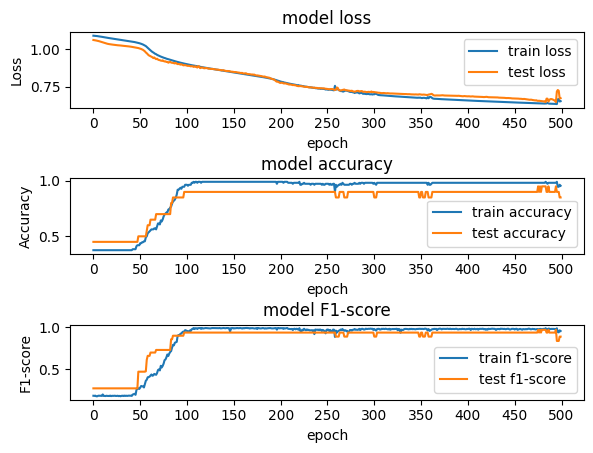

In [ ]:
plot_results(train_losses, train_accuracies, train_f1_scores, test_losses, test_accuracies, test_f1_scores, num_epochs=500)

### 4.3.1 Training on Cropped data with normalization

In [ ]:
X = get_video_begin(lm_arrays)
y = convert_to_class(movements)
X_train, X_test, y_train, y_test = generate_splits(X, y, norm=True)

train_dataset, train_dataloader, test_dataset, test_loader = get_sets_and_loaders(X_train, X_test, y_train, y_test)

In [ ]:
%%time
train_losses, train_accuracies,train_f1_scores, test_losses, test_accuracies, test_f1_scores = train_and_eval(
                                                                                              model, loss_func, optimizer,
                                                                                              train_dataset, train_dataloader,
                                                                                              test_dataset, test_loader,
                                                                                              num_epochs = 500)

Epoch [50/500], Train Loss: 1.0317

Test Loss: 1.0173, Test Accuracy: 0.8500

Epoch [100/500], Train Loss: 0.9158

Test Loss: 0.9142, Test Accuracy: 0.9500

Epoch [150/500], Train Loss: 0.7276

Test Loss: 0.7120, Test Accuracy: 1.0000

Epoch [200/500], Train Loss: 0.6686

Test Loss: 0.6545, Test Accuracy: 1.0000

Epoch [250/500], Train Loss: 0.6412

Test Loss: 0.6306, Test Accuracy: 1.0000

Epoch [300/500], Train Loss: 0.6235

Test Loss: 0.6152, Test Accuracy: 1.0000

Epoch [350/500], Train Loss: 0.6106

Test Loss: 0.6040, Test Accuracy: 1.0000

Epoch [400/500], Train Loss: 0.6006

Test Loss: 0.5953, Test Accuracy: 1.0000

Epoch [450/500], Train Loss: 0.5926

Test Loss: 0.5883, Test Accuracy: 1.0000

Epoch [500/500], Train Loss: 0.5862

Test Loss: 0.5826, Test Accuracy: 1.0000

CPU times: user 29.7 s, sys: 262 ms, total: 30 s
Wall time: 30.2 s


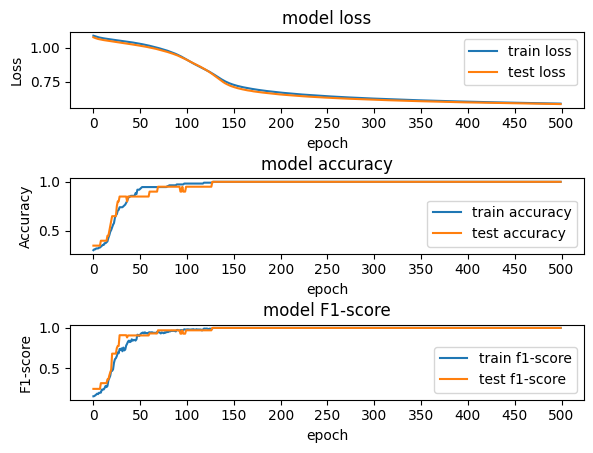

In [ ]:
plot_results(train_losses, train_accuracies, train_f1_scores, test_losses, test_accuracies, test_f1_scores, num_epochs=500)

## 4.4 Test Results

Having discarded our padding approach, we worked on the cropped data approach, which we used to train and test our models, with and without normalization.

As can we be seen from setions 4.3.1 and 4.3.2 above, the model trained on the normalized data has a better overall performance with lower loss, higher accuracy and F1-score.

Looking at the loss plot for the model with normalized data, we notice the absence of volatility losses of both sets. The time for training the model for the 500 epochs is less than 30 seconds.

# 5. CNN and LSTM Models using Video data

While using extracted landmark arrays for training has yielded encouraging results, it is useful to benchmark said results against training carried out using video data.

This can take two forms:

1.   One method that can be implemented is the classification of the landmark videos created. Using the current dataset, another has been created containing just the landmark data presented on a black background which will be used to train a new model. This model is created, trained and evaluated in Section 5.3.
2.   Another method is to use the the raw videos directly, without any feature extraction. This model is created, trained and evaluated in Section 5.4.

## 5.1 Specfic Pre-processing for Video data

The following function processes the videos to prepare them for the model. This is done by iterating through every video in the new dataset, choosing a random slice of the video to use (decided by the ‘FRAMES_PER_VIDEO’) before using OpenCV to export all the information about the video to a numpy array. The output of this is very similar to that of the data from the landmarks, however in this case it is the entire video which is transferred over, rather than just the landmark data. This returns a numpy array containing all the data for each video in ‘data’, alongside its respected classification in ‘labels’ - which is decided by the folder in the dataset the video is stored in.

In [ ]:
def preprocess_videos(dataset_dir, frames_per_video):
    data = []
    labels = []
    class_names = ['jerk', 'sumo', 'snatch']

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        for video_name in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video_name)
            video_frames = []
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_interval = frame_count // frames_per_video
            if frame_count > frames_per_video:
                start_frame = random.randint(0, frame_count - frames_per_video)
                frame_interval = 1
            else:
                start_frame = 0
                frame_interval = frame_count // frames_per_video

            for i in range(frames_per_video):
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + i * frame_interval)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.resize(frame, (156, 156))
                    frame = frame.astype(np.float32) / 156.0
                    video_frames.append(frame)

            if len(video_frames) == frames_per_video:
                data.append(video_frames)
                labels.append(tf.keras.utils.to_categorical(label, len(class_names)))

            cap.release()

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

## 5.2 Model Definition

The model used for this solution is not one, but rather two different models. The PyLSTM class implements an LSTM model, similar to that used for just the landmarks. However, the first layer of this model calls to another model, PyCNN, which is a CNN neural network.

CNN models are commonly used for image classification problems, most noticeably containing a convolution layer. The convolution layer, included in the first two layers of the CNN, slides a kernel over the input image, computing the dot product of all the values contained in the kernel before storing these values in a new array.

Multiple parameters can be chosen when initialising a convolutional layer, however in this case the ones chosen are the kernel size, being 3 and padding – which adds extra pixels around the input – being set as 1. Alongside this, a max-pooling layer has also been implemented, which down-samples the input by taking either the minimum, average, or maximum value in a given area and preserves that information. This is performed through another sliding window, this time set to (2, 2).

By incorporating both models each frame will be analysed through the CNN model, however the data will be retained throughout the entire video through the LSTM.

In [ ]:
class PyCNN(nn.Module):
    def __init__(self):
        super(PyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 39 * 39, 256)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 32 * 39 * 39)
        x = F.relu(self.fc1(x))
        return x

In [ ]:
class PyLSTM(nn.Module):
    def __init__(self, num_classes=3):
        super(PyLSTM, self).__init__()
        self.cnn = PyCNN()
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.lstm(r_in)
        r_out2 = self.fc(r_out[:, -1, :])

        return r_out2

## 5.3 Model using landmark video data

### 5.3.1 Data Pre-processing

In order to train the model defined above on landmark video, the first thing done is initialising the directory of the landmark videos, alongside the number of frames we want to process for each video – in this case 30.

In [ ]:
DATASET_DIR = "output"
FRAMES_PER_VIDEO = 30

We then use the video specific preprocessing function defined earlier to generate lists of landmark videos and labels (sub folder names)

In [ ]:
%%time

data, labels = preprocess_videos(DATASET_DIR, FRAMES_PER_VIDEO)

CPU times: user 6min 27s, sys: 19.3 s, total: 6min 46s
Wall time: 4min 37s


We also need to set up labels (y) and video data (X) to pass on to the training function.

Also, since training with video data is computationally intensive, we attempt to utilize the GPU installed on the machine.

In [ ]:
labels_new = np.argmax(labels, axis=1)
data_torch = tc.tensor(data).permute(0, 1, 4, 2, 3)
labels_torch = tc.tensor(labels_new)
device = tc.device("cuda" if tc.cuda.is_available() else "cpu")

Once the data and labels are ready for training, we can proceed to splitting the data into training and test sets and then creating PyTorch datasets and dataloader objects.

In [ ]:
X_train, X_test, y_train, y_test = generate_splits(data_torch, labels_torch, norm = False)
train_dataset, train_dataloader, test_dataset, test_loader = get_sets_and_loaders(X_train, X_test, y_train, y_test)

### 5.3.2 Model Creation
As a last step, before training, we create the model and assign it to the device selected above.

In [ ]:
model = PyLSTM().to(device)
loss = tc.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 5.3.3 Model Training

In [ ]:
%%time
train_losses, train_accuracies,train_f1_scores, test_losses, test_accuracies, test_f1_scores = train_and_eval(
                                                                                              model, loss, optimizer,
                                                                                              train_dataset, train_dataloader,
                                                                                              test_dataset, test_loader,
                                                                                              num_epochs = 10)

Epoch [1/10], Train Loss: 1.1603

Test Loss: 1.0873, Test Accuracy: 0.3500

Epoch [2/10], Train Loss: 1.0736

Test Loss: 1.0377, Test Accuracy: 0.5500

Epoch [3/10], Train Loss: 1.0095

Test Loss: 0.9024, Test Accuracy: 0.6500

Epoch [4/10], Train Loss: 0.8021

Test Loss: 0.6925, Test Accuracy: 0.7500

Epoch [5/10], Train Loss: 0.5503

Test Loss: 0.4895, Test Accuracy: 0.7500

Epoch [6/10], Train Loss: 0.3534

Test Loss: 0.3993, Test Accuracy: 0.9000

Epoch [7/10], Train Loss: 0.2506

Test Loss: 0.3185, Test Accuracy: 0.8000

Epoch [8/10], Train Loss: 0.1663

Test Loss: 0.3021, Test Accuracy: 0.9000

Epoch [9/10], Train Loss: 0.1104

Test Loss: 0.2602, Test Accuracy: 0.9000

Epoch [10/10], Train Loss: 0.0694

Test Loss: 0.2573, Test Accuracy: 0.9000

CPU times: user 6min 37s, sys: 4min 3s, total: 10min 41s
Wall time: 10min 43s


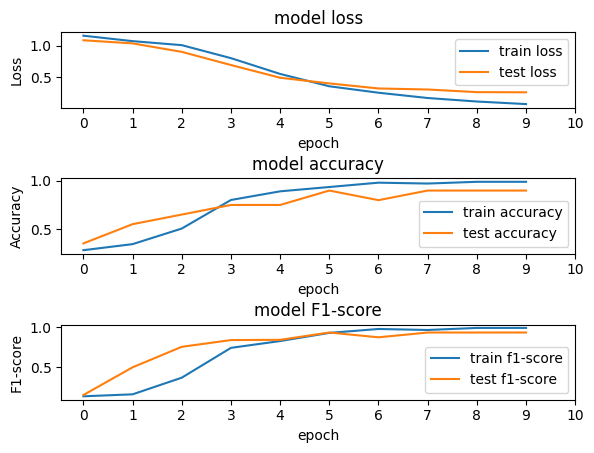

In [ ]:
plot_results(train_losses, train_accuracies, train_f1_scores, test_losses, test_accuracies, test_f1_scores, num_epochs=10)

### 5.3.4 Test Results

By implementing the CNN and LSTM models together on landmark videos, a validation accuracy of 0.9 is returned. The loss of the test set is slightly higher than the training set.

Also, the results don't come without cost, as a much higher computational demand is seen when using this approach. Performing 10 epochs on this model takes up a total time of nearly 11 minutes, which is over 2000% slower than the landmark array model. Alongside this, the required ‘preprocess_videos’ function also shows a heavy compute time – clocking in at just over 4 minutes.

## 5.4 Model using Raw video data

### 5.4.1 Data Pre-processing

In order to train the model defined above on raw videos, the first thing done is initialising the directory of the raw videos, alongside the number of frames we want to process for each video, which was defined prior with a value of 30.

In [ ]:
DATASET_DIR = "data"

We then use the video specific preprocessing function defined earlier to generate lists of landmark videos and labels (sub folder names)

In [ ]:
%%time

data, labels = preprocess_videos(DATASET_DIR, FRAMES_PER_VIDEO)

CPU times: user 50min 40s, sys: 38.7 s, total: 51min 18s
Wall time: 31min 19s


We also need to set up labels (y) and video data (X) to pass on to the training function.

Also, since training with video data is computationally intensive, we attempt to utilize the GPU installed on the machine.

In [ ]:
labels_new = np.argmax(labels, axis=1)
data_torch = tc.tensor(data).permute(0, 1, 4, 2, 3)
labels_torch = tc.tensor(labels_new)
device = tc.device("cuda" if tc.cuda.is_available() else "cpu")

Once the data and labels are ready for training, we can proceed to splitting the data into training and test sets and then creating PyTorch datasets and dataloader objects.

In [ ]:
X_train, X_test, y_train, y_test = generate_splits(data_torch, labels_torch, norm = False)
train_dataset, train_dataloader, test_dataset, test_loader = get_sets_and_loaders(X_train, X_test, y_train, y_test)

### 5.4.2 Model Creation
As a last step, before training, we create the model and assign it to the device selected above.

In [ ]:
model = PyLSTM().to(device)
loss = tc.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

### 5.4.3 Model Training

In [ ]:
%%time
train_losses, train_accuracies,train_f1_scores, test_losses, test_accuracies, test_f1_scores = train_and_eval(
                                                                                              model, loss, optimizer,
                                                                                              train_dataset, train_dataloader,
                                                                                              test_dataset, test_loader,
                                                                                              num_epochs = 10)

Epoch [1/10], Train Loss: 0.8487

Test Loss: 0.4096, Test Accuracy: 0.9000

Epoch [2/10], Train Loss: 0.3347

Test Loss: 0.1321, Test Accuracy: 1.0000

Epoch [3/10], Train Loss: 0.1378

Test Loss: 0.0566, Test Accuracy: 1.0000

Epoch [4/10], Train Loss: 0.0771

Test Loss: 0.0245, Test Accuracy: 1.0000

Epoch [5/10], Train Loss: 0.0634

Test Loss: 0.0160, Test Accuracy: 1.0000

Epoch [6/10], Train Loss: 0.0523

Test Loss: 0.0154, Test Accuracy: 1.0000

Epoch [7/10], Train Loss: 0.0996

Test Loss: 0.0181, Test Accuracy: 1.0000

Epoch [8/10], Train Loss: 0.0635

Test Loss: 0.0274, Test Accuracy: 1.0000

Epoch [9/10], Train Loss: 0.0583

Test Loss: 0.0104, Test Accuracy: 1.0000

Epoch [10/10], Train Loss: 0.0461

Test Loss: 0.0106, Test Accuracy: 1.0000

CPU times: user 6min 32s, sys: 4min 4s, total: 10min 37s
Wall time: 10min 40s


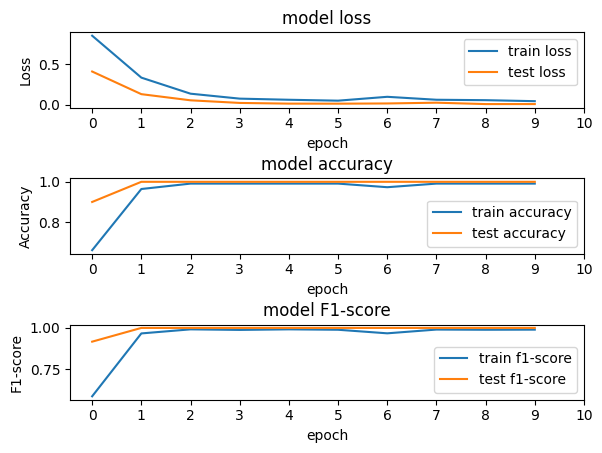

In [ ]:
plot_results(train_losses, train_accuracies, train_f1_scores, test_losses, test_accuracies, test_f1_scores, num_epochs=10)

### 5.4.4 Test Results

By implementing the CNN and LSTM models together on raw videos, a validation accuracy of 1.0 is returned. There is little difference betweenn test and training set losses which indicated a good fit.  

Similar to the landmark vidoes in the previous section, a much higher computational demand is seen when using this approach. Performing 10 epochs on this model also takes up a total time of nearly 11 minutes, which is over 2000% slower than the landmark array model. Alongside this, the required ‘preprocess_videos’ function also shows a heavy compute time – clocking in at over 31 minutes to pre-process the raw video dataset.

#6. Model Evaluation
We will evaluate the performance of our three models, built in Sections 4 and 5 using the following metrics.

1.  Test Loss
2.  Test Accuracy
3.  Test F1 score
4.  Time

The below table compares the performance:

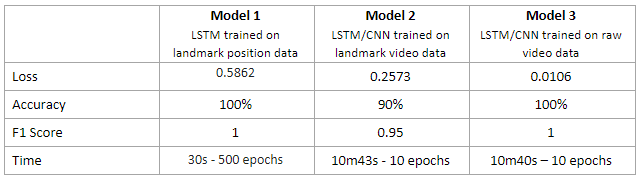


*   **Loss:** Model 3 with raw video training has the best loss. Model 2, which uses landmark video data is second. Model 1, has the highest loss, and is 100% higher than Model 2.

*   **Accuracy:** Model 1 and 3 show a perfect accuracy score. Model 3's results are clearly the best in terms of model accuracy and reliability. Model 1 is highly accurate, yet has lower reliability, which we believe is a problem that can be resolved by providing more training data.

*   **F1-Score:** The f1-score shows a similar pattern to the above metrics (as is usual for multi-classification problems with balanced classes).

* **Time:** Time is of utmost importance to our problem statement. The goal of the project is to expand in terms of number of exercises classified. Considering that there are hundreds of exercises, the training time required for Models 2 and 3 become prohibitive, even considering the excellent performance of Model 3 on other metrics. With this context, Model 1, as per our original thesis, provides a fast training time due to working with numpy arrays and (equally importantly) not training on a data format as intensive as video.

* We believe that increasing the dataset size to train the model on more examples of each lift, with varying camera angles and movement patterns (achieved at a subtle level for instance with varying loads) will improve it's validation loss even further, thus making it suitable for production usage.




# 7. Discussion and Lesssons Learned
## 7.1 Fulfilment of Objects
**Objective 1: Track athletes’ skeletal model through each movement**

We have been able to implement this through Mediapipe BlazePose library as well as converting the pose landmark output to Numpy arrays.

**Objective 2: Use movement tracking to classify multiple movements with a high degree of accuracy**

Our Model 1, built and elaborated in Section 4, performs at a very high level of accuracy, confidence, precision and recall. After appropriate pre-processing (cropping, normalization) and model tuning, our best iteration of model achieves a loss of 0.5862 (highly convered between test and training sets) with an accuracy of 100%  

**Objective 3: Implement and Evaluate performance of multiple classification models**

We've used an LSTM model with landmark array dataset as well as combination of CNN, LSTM model with both landmark and raw vidoes. This gives us reasonable vareity of classification and data processing approaches for this project.

## 7.2 Constraints
While working on the project, we came across several constraints that impact the accuracy of our model.
1.	Resolution: Since the data collected were from various sources, this means the level of detail and complexity from each of the sources differs because of different camera qualities used in taking the shots. When exporting the data from the editing software we noticed frame drops and decrease in the resolution. Since higher resolution means a high level of detail, this means the model would be able to make use of these levels of details for its analysis, and as such, better performance of the model. This was however managed by standardizing the videos using video editing software.

2.	Camera angle: As mentioned above, the videos are from various sources. As such, difference in field of view and angle. This means for some of the data, the position may not be captured accurately, thereby impacting the model's accuracy. This was considered, and only data with desired camera angles were selected.

3.	Lighting: The lighting condition of the data was also considered as it played a significant role in the level of detail the data has. The model may be unable to track the detailed points, reducing its accuracy.
